# Effective Mass Calculations

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [2]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [3]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

TODO: make plot for the symmetric case that compares with the perturbation theory - now fixed the coupling points for which we want to compare! Cluster calculations for this are running, don't forget to collect them!! Also, a side benefit is that they provide nice convergence with system size calculations now!!

In [4]:
def var_eff_mass(E_q, E_0, t, M):
    m_0_finite_diff = (t*M**2*(1-np.cos(2*np.pi/M))/np.pi**2)**(-1)
    return ((2*(E_q-E_0)/(2*np.pi/M)**2)**(-1))/m_0_finite_diff

### Ferroelectric order effective mass

In [5]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo = np.array([2,4,20,40,60,80,100])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_B_2_q0 = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_B_2_qx = get_E_arr(V_0_range_fo, folder, check_sys, check_sym)


V_0_range_fo_B_200 = np.array([2,4,20])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_200.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_B_200_q0 = get_E_arr(V_0_range_fo_B_200, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_B_200_qx = get_E_arr(V_0_range_fo_B_200, folder, check_sys, check_sym)

In [6]:
def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo = var_eff_mass(E_vGH_fo_B_2_qx, E_vGH_fo_B_2_q0, tx, Mx)
print('B = 2; V, mx =', V_0_range_fo, mx_fo)

mx_fo_B_200 = var_eff_mass(E_vGH_fo_B_200_qx, E_vGH_fo_B_200_q0, tx, Mx)
print('B = 200; V, mx =', V_0_range_fo_B_200, mx_fo_B_200)

popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo, mx_fo.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit = np.linspace(V_0_range_fo[0], V_0_range_fo[-1], 100)
y_fit = func(x_fit, *popt)

print('\nFit params =', popt)

B = 2; V, mx = [  2   4  20  40  60  80 100] [1.00026131-9.01009509e-15j 1.00110194+9.02382594e-15j
 1.02948376+3.09628763e-14j 1.12157874+5.74958358e-15j
 1.28616856-2.62099845e-16j 1.54617687-1.14196437e-14j
 1.94922781-9.26774791e-14j]
B = 200; V, mx = [ 2  4 20] [1.00003368-4.50293896e-15j 1.00013225-6.77326028e-15j
 1.00332125-2.24483705e-15j]

Fit params = [1.00000000e+00 2.00000000e+00 9.08090548e-05]


/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


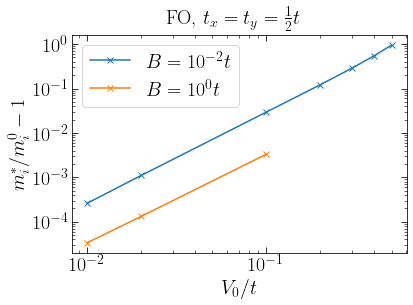

In [7]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')
#axs.plot(x_fit/t, y_fit.real-1, color='tab:blue', linestyle='dashed', label=r'polynomial fit')

axs.plot(V_0_range_fo_B_200/t, mx_fo_B_200.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$B = 10^{0} t$')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

### Ferro-domain wall effective mass

#### Symmetric Lattice

In [8]:
tx = 100.0
ty = 100.0
t = tx+ty

B = 2.0
Mx_fdv = 8
My_fdv = 256

V_0_range_fdv = np.array([40,60,80,100,120,140])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_0'
folder = 'results/eff_mass/fdv/'
E_vGH_fdv_B_2_q0 = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_8_My_256_qx_0_qy_1'
E_vGH_fdv_B_2_qy = get_E_arr(V_0_range_fdv, folder, check_sys, check_sym)



V_0_range_fdv_x = np.array([100])

check_sym = '_B_2.0_Mx_32_My_128_qx_0_qy_0'
E_vGH_fdv_B_2_q0x = get_E_arr(V_0_range_fdv_x, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_128_qx_1_qy_0'
E_vGH_fdv_B_2_qx = get_E_arr(V_0_range_fdv_x, folder, check_sys, check_sym)

In [9]:
my_fdv = var_eff_mass(E_vGH_fdv_B_2_qy, E_vGH_fdv_B_2_q0, ty, My_fdv)
mx_fdv = var_eff_mass(E_vGH_fdv_B_2_qx, E_vGH_fdv_B_2_q0x, tx, 32)

print('my =', my_fdv)
print('mx =', mx_fdv)

my = [ 8.83724151+4.45500380e-11j 11.75131569+7.89254680e-11j
 14.00723719+1.06157665e-10j 15.96870625-2.15776103e-11j
 17.86564878+3.15117454e-11j 19.93322696-2.17182533e-10j]
mx = [8905158.8713718-0.00235072j]


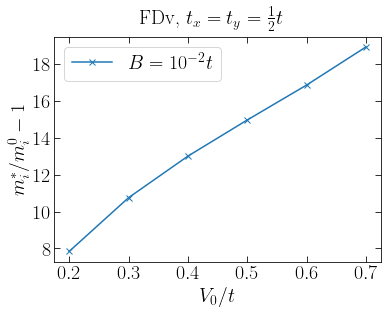

In [10]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FDv, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$B = 10^{-2} t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_fdv/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
#axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

TODO: calculate the effective mass here for the FDW perpendicular direction - also verify what the FDW$_y$ states really are, I suspect they are small polaron states. Here is a mental note - the FDv states don't make sense as here they correspond to SP states, i.e. they converged to the higher energy branch.

### Small polaron effective mass

In [15]:
tx = 100
ty = 100
t = tx+ty

B = 2.0
Mx_sp = 32
My_sp = 32

V_0_range_sp = np.array([150,170,190,210,250,300,350,500,1000,1500])

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_0'
folder = 'results/eff_mass/sp/'
E_vGH_sp_B_2_q0 = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_0_qy_1'
E_vGH_sp_B_2_qy = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_32_My_32_qx_1_qy_0'
E_vGH_sp_B_2_qx = get_E_arr(V_0_range_sp, folder, check_sys, check_sym)

In [16]:
mx_sp = var_eff_mass(E_vGH_sp_B_2_qx, E_vGH_sp_B_2_q0, tx, Mx_sp)
my_sp = var_eff_mass(E_vGH_sp_B_2_qy, E_vGH_sp_B_2_q0, ty, My_sp)

print('mx =', mx_sp)
print('my =', my_sp)

mx = [2.66043406e+04+1.18450569e-08j 4.66356776e+04-1.16657864e-07j
 7.84379751e+04+7.20475446e-08j 1.27685843e+05-1.08039650e-07j
 3.13612097e+05+1.88008936e-05j 8.65483655e+05+2.00730373e-04j
 2.18302154e+06-3.12997133e-04j 2.42281640e+07-1.23238137e-02j
 9.66901951e+09+2.30141492e+04j 8.45072282e+11-1.38527603e+08j]
my = [2.66043323e+04-5.13769130e-08j 4.66356773e+04-3.57928708e-08j
 7.84380310e+04-4.18060477e-07j 1.27685714e+05-5.40129665e-07j
 3.13612178e+05+1.18421418e-05j 8.65485871e+05-1.85735372e-06j
 2.18282841e+06-1.47520424e-04j 2.42279904e+07+2.92117311e-02j
 9.69119616e+09+9.29557342e+03j 1.40845368e+12-4.74020249e+08j]


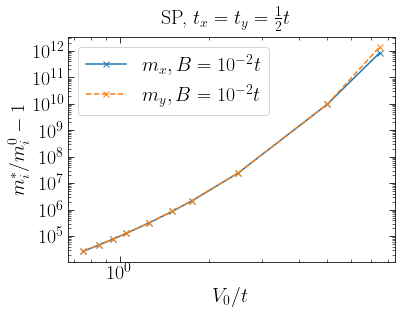

In [17]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'SP, $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range_sp/t, mx_sp.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs.plot(V_0_range_sp/t, my_sp.real-1, color='tab:orange', marker='x', linestyle='dashed', label=r'$m_y, B = 10^{-2} t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_sp/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

### Effective mass overview in all regimes

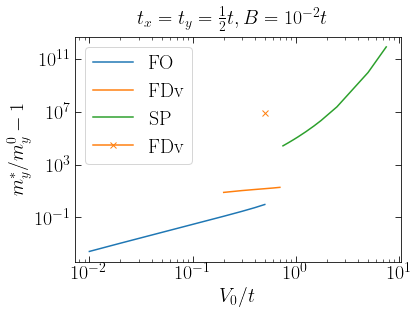

In [18]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'$t_x=t_y=\frac{1}{2}t, B = 10^{-2} t$', fontsize=font_size)

axs.plot(V_0_range_fo/t, mx_fo.real-1, color='tab:blue', linestyle='solid', label=r'FO')
axs.plot(V_0_range_fdv/t, my_fdv.real-1, color='tab:orange', linestyle='solid', label=r'FDv')
axs.plot(V_0_range_sp/t, mx_sp.real-1, color='tab:green', linestyle='solid', label=r'SP')


axs.plot(V_0_range_fdv_x/t, mx_fdv.real-1, marker='x', color='tab:orange', linestyle='solid', label=r'FDv')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_y^*/m_y^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
plt.tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True, labelsize=font_size)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True, labelsize=font_size)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/eff_mass/eff_mass_sym_case_B_2.0.pdf', bbox_inches='tight', dpi=50)

## Ferro-Order Effective Masses in asymmetric regime

In [19]:
tx = 150
ty = 50
t = tx+ty

B = 2.0
Mx = 80
My = 80

V_0_range_fo_as = np.array([2,4,20,50])

check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH_fo_as_B_2_q0 = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_1_qy_0'
E_vGH_fo_as_B_2_qx = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_80_My_80_qx_0_qy_1'
E_vGH_fo_as_B_2_qy = get_E_arr(V_0_range_fo_as, folder, check_sys, check_sym)

In [20]:
import scipy 

def func(x, a, b, c):
    return 1+0*x+c*x**2 #a*np.exp(b*x)+c # 
    
mx_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qx, E_vGH_fo_as_B_2_q0, tx, Mx)
print('mx =', mx_fo_as)

my_fo_as = var_eff_mass(E_vGH_fo_as_B_2_qy, E_vGH_fo_as_B_2_q0, ty, My)
print('my =', my_fo_as)

popt, pcov = scipy.optimize.curve_fit(func, V_0_range_fo_as, mx_fo_as.real, p0 = [1, 2, 1]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit_as = np.linspace(V_0_range_fo_as[0], V_0_range_fo_as[-1], 100)
y_fit_as = func(x_fit_as, *popt)

print('\nFit params =', popt)

mx = [1.00031841-4.50693934e-15j 1.00133164-1.58002282e-14j
 1.03523986+2.65205328e-14j 1.23412407+6.58597677e-15j]
my = [1.00044992-3.60436422e-14j 1.001883  +1.35557019e-14j
 1.05014679-3.95597231e-14j 1.35614178+7.08469151e-14j]

Fit params = [1.00000000e+00 2.00000000e+00 9.35106494e-05]


/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


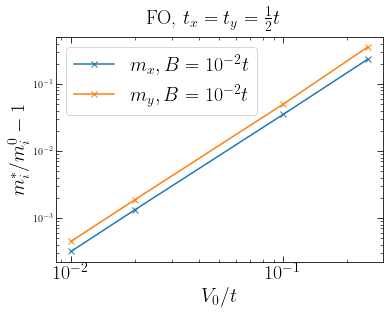

In [71]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FO, $t_x=\frac{3}{4}t, t_y=\frac{1}{4}t$', fontsize=font_size)

axs.plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs.plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y, B = 10^{-2} t$')
#axs.plot(x_fit_as/t, y_fit_as.real-1, color='tab:blue', linestyle='dashed', label=r'polynomial fit')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

TODO: just started the calculations for the domain walls in the asymmetric case to get the plot for the effective mass in the asymmetric cases. Collect the results here!

In [68]:
tx = 150.0
ty = 50.0
t = tx+ty

B = 2.0
Mx_fdv = 4
My_fdv = 128

V_0_range_fdv_as = np.array([50,100,150,200,250])

'''
FDv
'''
check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_4_My_128_qx_0_qy_0'
folder = 'results/eff_mass/fdv/'
E_vGH_fdv_as_B_2_q0 = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_4_My_128_qx_0_qy_1'
E_vGH_fdv_as_B_2_qy = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)


''' 
Fdh
'''
check_sys = 'tx_150.0_ty_50.0'
check_sym = '_B_2.0_Mx_128_My_4_qx_0_qy_0'
folder = 'results/eff_mass/fdh/'
E_vGH_fdh_as_B_2_q0 = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_128_My_4_qx_1_qy_0'
E_vGH_fdh_as_B_2_qx = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

check_sym = '_B_2.0_Mx_128_My_32_qx_0_qy_1'
E_vGH_fdh_as_B_2_qy = get_E_arr(V_0_range_fdv_as, folder, check_sys, check_sym)

In [69]:
my_fdv_as = var_eff_mass(E_vGH_fdv_as_B_2_qy, E_vGH_fdv_as_B_2_q0, 50, 128)

mx_fdh_as = var_eff_mass(E_vGH_fdh_as_B_2_qx, E_vGH_fdh_as_B_2_q0, 150, 128)
my_fdh_as = var_eff_mass(E_vGH_fdh_as_B_2_qy, E_vGH_fdh_as_B_2_q0, 50, 32)

print('FDv, my =', my_fdv_as)

print('FDh, mx =', mx_fdh_as)
print('FDh, my =', my_fdh_as)

FDv, my = [1.05581123e+01+3.94535357e-12j 4.87519910e+03+3.07078974e-08j
 2.29187684e+04-1.06499051e-06j 1.00902453e+05-3.14907043e-05j
 3.14392608e+05+4.63433116e-04j]
FDh, mx = [10.53474265-2.55620827e-12j 16.34278721-1.08420315e-11j
 20.21898502-9.27958554e-12j 23.79362249-3.06419729e-12j
 28.75540677+1.03840897e-11j]
FDh, my = [2.93711680e+05-3.24429118e-06j 7.40143948e+07+8.16323527e-02j
 2.81639134e+08+3.26164394e+00j 2.43954025e-03+8.97663641e-23j
 2.04370554e-03-2.28139444e-22j]


TODO: calculate the effective mass here for the FDW perpendicular direction - calculation is still running, should be finished after Budapest.

A remark about the FDv states - they don't make sense as here they correspond to SP states, i.e. they converged to the higher energy branch somehow. Though that's not too unexpected since we are in the regime where the FDh is the definite ground state.

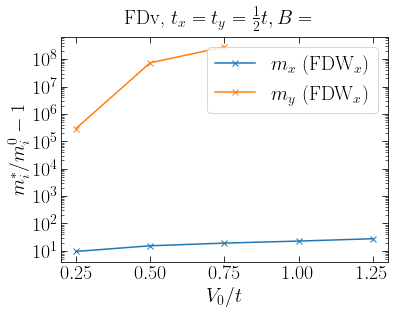

In [71]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'FDv, $t_x=t_y=\frac{1}{2}t, B=$', fontsize=font_size)

#axs.plot(V_0_range_fdv_as/t, my_fdv_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_y (FDW_y)$')
axs.plot(V_0_range_fdv_as/t, mx_fdh_as.real-1, color='tab:blue', marker='x', linestyle='solid', label=r'$m_x$ (FDW$_x$)')
axs.plot(V_0_range_fdv_as[0:3]/t, my_fdh_as.real[0:3]-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y$ (FDW$_x$)')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m_i^*/m_i^0-1$', fontsize=font_size)

plt.xticks(V_0_range_fdv_as/t, fontsize=font_size)
plt.yticks(fontsize=font_size)

#axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

#axs.invert_yaxis()
#axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
#axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

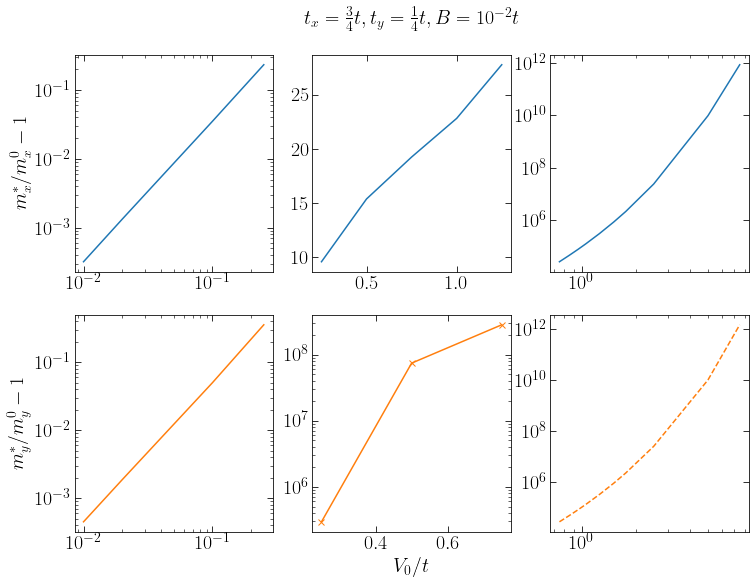

In [76]:
A = 4
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots(2,3)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

plt.suptitle(r'$t_x=\frac{3}{4}t, t_y=\frac{1}{4}t, B=10^{-2}t$', fontsize=font_size)

axs[0,0].plot(V_0_range_fo_as/t, mx_fo_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs[1,0].plot(V_0_range_fo_as/t, my_fo_as.real-1, color='tab:orange', linestyle='solid', label=r'$m_y, B = 10^{-2} t$')

axs[0,0].set_xscale('log', base=10)
axs[0,0].set_yscale('log', base=10)

axs[1,0].set_xscale('log', base=10)
axs[1,0].set_yscale('log', base=10)


axs[0,1].plot(V_0_range_fdv_as/t, mx_fdh_as.real-1, color='tab:blue', linestyle='solid', label=r'$m_x$ (FDW$_x$)')
axs[1,1].plot(V_0_range_fdv_as[0:3]/t, my_fdh_as.real[0:3]-1, color='tab:orange', marker='x', linestyle='solid', label=r'$m_y$ (FDW$_x$)')

#axs[1,1].set_xscale('log', base=10)
axs[1,1].set_yscale('log', base=10)

axs[0,2].plot(V_0_range_sp/t, mx_sp.real-1, color='tab:blue', linestyle='solid', label=r'$m_x, B = 10^{-2} t$')
axs[1,2].plot(V_0_range_sp/t, my_sp.real-1, color='tab:orange', linestyle='dashed', label=r'$m_y, B = 10^{-2} t$')

axs[0,2].set_xscale('log', base=10)
axs[0,2].set_yscale('log', base=10)

axs[1,2].set_xscale('log', base=10)
axs[1,2].set_yscale('log', base=10)

axs[1,1].set_xlabel(r'$V_0/t$', fontsize=font_size)
axs[0,0].set_ylabel(r'$m_x^*/m_x^0-1$', fontsize=font_size)
axs[1,0].set_ylabel(r'$m_y^*/m_y^0-1$', fontsize=font_size)

#axs[0,0].set_xticks(V_0_range_fo_as/t, str(V_0_range_fo_as/t), fontsize=font_size)
#axs[0,0].set_yticks(fontsize=font_size)

axs[0,0].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[0,0].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[0,0].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[0,0].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

axs[1,0].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[1,0].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[1,0].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[1,0].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

axs[0,1].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[0,1].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[0,1].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[0,1].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

axs[1,1].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[1,1].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[1,1].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[1,1].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

axs[0,2].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[0,2].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[0,2].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[0,2].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

axs[1,2].tick_params(axis='x', direction='in', length=6, top=True, labelsize=font_size)
axs[1,2].tick_params(axis='y', direction='in', length=6, right=True, labelsize=font_size)
axs[1,2].tick_params(axis='x', which='minor', direction='in', length=3, top=True)
axs[1,2].tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

#plt.savefig('results/eff_mass/eff_mass_asym_case_B_2.0_sum.pdf', bbox_inches='tight', dpi=50)